In [1]:
from matplotlib.ticker import FormatStrFormatter as fsf
import matplotlib.pyplot as plt
from plots.mpltoolkit import mpl_loc, named_colors, markers, fancy_legend, negative_log, load_style_sheet
# from plots.mpltoolkit import mpl_loc, named_colors, markers, fancy_legend, load_style_sheet
import numpy as np
import math as m
import vice
import sys
import os
sys.path.append("..")
from src.utils import mu, get_velocity_profile, boxcarsmoothtrend, oh_to_12pluslog
load_style_sheet("papers")
print(sys.version_info)

/Users/jamesjohnson/Work/Research/lib/public-dev/VICE/vice/__init__.py:141: UserWarning: Using un-released version of VICE
  warnings.warn("Using un-released version of VICE", UserWarning)


sys.version_info(major=3, minor=12, micro=3, releaselevel='final', serial=0)


In [4]:
outputs = [
    "../outputs/constant/vgas-0p5-centraloutflow",
    "../outputs/constant/vgas-1-centraloutflow",
    "../outputs/constant/vgas-1p5-centraloutflow"
]
outputs = [vice.output(name) for name in outputs]

/Users/jamesjohnson/Work/Research/lib/personal/plots/mpltoolkit/core.py:96: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(labels)


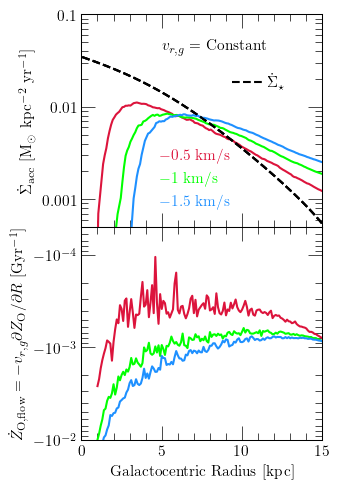

In [5]:
COLORS = ["crimson", "lime", "dodgerblue"]
LABELS = [r"$-0.5$ km/s", r"$-1$ km/s", r"$-1.5$ km/s"]

fig = plt.figure(figsize = (3.5, 5))
ax1 = fig.add_subplot(211)
ax1.set_ylabel(r"$\dot\Sigma_\text{acc}$ [M$_\odot$ kpc$^{-2}$ yr$^{-1}$]", fontsize = 11)
plt.setp(ax1.get_xticklabels(), visible = False)
ax1.tick_params(labelsize = 11)
ax1.set_xlim([0, 15])
ax1.set_ylim([5.0e-4, 0.1])
ax1.set_yscale("log")
ax1.yaxis.set_major_formatter(fsf("%g"))
ax1.text(5, 0.04, r"$v_{r,g} = $ Constant", fontsize = 11)
ax2 = fig.add_subplot(212, sharex = ax1)
ax2.set_xlabel(r"Galactocentric Radius [kpc]", fontsize = 11)
ax2.set_ylabel(r"$\dot{Z}_\text{O,flow} = -v_{r,g} \partial Z_\text{O} / \partial R$ [Gyr$^{-1}$]", fontsize = 11)
ax2.set_ylim([5.0e-5, 0.01])
ax2.set_yscale("log")
ax2.tick_params(labelsize = 11)
# ax2.yaxis.set_major_formatter(fsf("%g"))

# line1 = ax1.plot([1, 2], [1, 2], c = named_colors()["black"], linestyle = "-", label = r"$\dot\Sigma_\text{acc}$")[0]
line2 = ax1.plot([1, 2], [1, 2], c = named_colors()["black"], linestyle = "--", label = r"$\dot\Sigma_\star$")[0]
kwargs = {
    "loc": mpl_loc("lower right"),
    "bbox_to_anchor": (0.9, 0.58),
    "fontsize": 11,
    "handlelength": 2
}
leg = ax1.legend(**kwargs)
ax1.add_artist(leg)
# line1.remove()
line2.remove()

def boxcarsmoothtrend(xvals, yvals, window = 5):
    newyvals = []
    for i in range(len(xvals)):
        start = max(0, i - window)
        stop = min(i + window, len(xvals) - 1)
        newyvals.append(np.mean(yvals[start:stop]))
    return newyvals

def plot_surface_densities(ax, output, lookback = 0, zone_width = 0.1, **kwargs):
    diff = [abs(_ - lookback) for _ in output.zones["zone0"].history["lookback"]]
    idx = diff.index(min(diff))
    radii = [zone_width * (i + 0.5) for i in range(len(output.zones.keys()))]
    sigma_sfr = []
    sigma_ifr = []
    for i in range(len(radii)):
        zone = output.zones["zone%d" % (i)]
        area = np.pi * zone_width**2 * ((i + 1)**2 - i**2)
        sigma_sfr.append(zone.history["sfr"][idx] / area)
        sigma_ifr.append(zone.history["ifr"][idx] / area)
    sigma_ifr = boxcarsmoothtrend(radii, sigma_ifr)
    start = int(1 / zone_width)
    ax.plot(radii, sigma_ifr, **kwargs)
    kwargs["c"] = named_colors()["black"]
    kwargs["linestyle"] = "--"
    kwargs["label"] = None
    ax.plot(radii, sigma_sfr, **kwargs)

def plot_mixing_rates(ax, output, lookback = 0, zone_width = 0.1, **kwargs):
    diff = [abs(_ - lookback) for _ in output.zones["zone0"].history["lookback"]]
    idx = diff.index(min(diff))
    if os.path.exists("%s_gasvelocities.out" % (output.name)):
        radii, vgas = get_velocity_profile(output, lookback)
    else:
        radii = [zone_width * (i + 0.5) for i in range(len(output.zones.keys()))]
        vgas = len(radii) * [0.]
    arr = []
    for i in range(len(radii)):
        zone = output.zones["zone%d" % (i)]
        area = np.pi * zone_width**2 * ((i + 1)**2 - i**2)
        if i < len(radii) - 1:
            neighbor = output.zones["zone%d" % (i + 1)]
            # tau_star = zone.history["mgas"][idx] / zone.history["sfr"][idx] * 1.0e-9
            # dlnzdr = (neighbor.history["z(o)"][idx] - zone.history["z(o)"][idx]) / (zone.history["z(o)"][idx] * zone_width)
            # arr.append(tau_star * vgas[i] * dlnzdr)
            dzdr = (neighbor.history["z(o)"][idx] - zone.history["z(o)"][idx]) / zone_width
            arr.append(vgas[i] * dzdr)
        else:
            arr.append(float("nan"))
    start = int(1 / zone_width)
    ax.plot(radii[start:], arr[start:], **kwargs)

for i in range(len(outputs)):
    kwargs = {
        "c": named_colors()[COLORS[i]],
        "label": LABELS[i]
    }
    plot_surface_densities(ax1, outputs[i], **kwargs)
    plot_mixing_rates(ax2, outputs[i], **kwargs)

kwargs = {
    "loc": mpl_loc("lower left"),
    "bbox_to_anchor": (0.25, 0.02),
    "handlelength": 0,
    "ncol": 1,
    "fontsize": 11
}
leg = ax1.legend(**kwargs)
fancy_legend(leg, COLORS)

negative_log(ax2)
plt.tight_layout()
plt.subplots_adjust(hspace = 0)
for ext in ["pdf", "jpeg"]:
    kwargs = {}
    if ext == "jpeg": kwargs["dpi"] = 200
    plt.savefig("./sfr-ifr/ifrshift-mixing-constant.%s" % (ext), **kwargs)
plt.show()

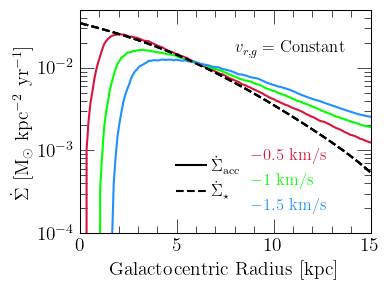

In [66]:
COLORS = ["crimson", "lime", "dodgerblue"]
LABELS = [r"$-0.5$ km/s", r"$-1$ km/s", r"$-1.5$ km/s"]

fig = plt.figure(figsize = (4, 3))
ax = fig.add_subplot(111)
ax.set_xlabel(r"Galactocentric Radius [kpc]")
ax.set_ylabel(r"$\dot\Sigma$ [M$_\odot$ kpc$^{-2}$ yr$^{-1}$]")
ax.set_xlim([0, 15])
ax.set_ylim([1.0e-4, 0.05])
ax.set_yscale("log")
ax.text(8, 0.015, r"$v_{r,g} = $ Constant", fontsize = 12)

line1 = ax.plot([1, 2], [1, 2], c = named_colors()["black"], linestyle = "-", label = r"$\dot\Sigma_\text{acc}$")[0]
line2 = ax.plot([1, 2], [1, 2], c = named_colors()["black"], linestyle = "--", label = r"$\dot\Sigma_\star$")[0]
kwargs = {
    "loc": mpl_loc("lower right"),
    "bbox_to_anchor": (0.6, 0.08),
    "fontsize": 12,
    "handlelength": 1.8
}
leg = ax.legend(**kwargs)
ax.add_artist(leg)
line1.remove()
line2.remove()

def boxcarsmoothtrend(xvals, yvals, window = 5):
    newyvals = []
    for i in range(len(xvals)):
        start = max(0, i - window)
        stop = min(i + window, len(xvals) - 1)
        newyvals.append(np.mean(yvals[start:stop]))
    return newyvals

def plot_surface_densities(ax, output, lookback = 0, zone_width = 0.1, **kwargs):
    diff = [abs(_ - lookback) for _ in output.zones["zone0"].history["lookback"]]
    idx = diff.index(min(diff))
    radii = [zone_width * (i + 0.5) for i in range(len(output.zones.keys()))]
    sigma_sfr = []
    sigma_ifr = []
    for i in range(len(radii)):
        zone = output.zones["zone%d" % (i)]
        area = np.pi * zone_width**2 * ((i + 1)**2 - i**2)
        sigma_sfr.append(zone.history["sfr"][idx] / area)
        sigma_ifr.append(zone.history["ifr"][idx] / area)
    sigma_ifr = boxcarsmoothtrend(radii, sigma_ifr)
    start = int(1 / zone_width)
    ax.plot(radii, sigma_ifr, **kwargs)
    kwargs["c"] = named_colors()["black"]
    kwargs["linestyle"] = "--"
    kwargs["label"] = None
    ax.plot(radii, sigma_sfr, **kwargs)

for i in range(len(outputs)):
    kwargs = {
        "c": named_colors()[COLORS[i]],
        "label": LABELS[i]
    }
    plot_surface_densities(ax, outputs[i], **kwargs)

kwargs = {
    "loc": mpl_loc("lower right"),
    "bbox_to_anchor": (0.9, 0.02),
    "handlelength": 0,
    "ncol": 1,
    "fontsize": 12
}
leg = ax.legend(**kwargs)
fancy_legend(leg, COLORS)

plt.tight_layout()
for ext in ["pdf", "jpeg"]:
    kwargs = {}
    if ext == "jpeg": kwargs["dpi"] = 200
    plt.savefig("./sfr-ifr/ifrshift-constant.%s" % (ext), **kwargs)
plt.show()

In [6]:
outputs = [
    # r"../outputs/constant/vgas-0",
    r"../outputs/constant/vgas-0p5-centraloutflow",
    r"../outputs/constant/vgas-1-highres",
    r"../outputs/constant/vgas-1p5-centraloutflow",
    r"../outputs/linear/dvdr-0p02-centraloutflow",
    r"../outputs/linear/dvdr-0p05-highres",
    r"../outputs/linear/dvdr-0p08-centraloutflow",
    r"../outputs/potential-well-deepening/gamma0p1",
    r"../outputs/potential-well-deepening/gamma0p2-highres",
    r"../outputs/potential-well-deepening/gamma0p3",
    r"../outputs/angular-momentum-dilution/betaphiin0p8",
    r"../outputs/angular-momentum-dilution/betaphiin0p7-highres",
    r"../outputs/angular-momentum-dilution/betaphiin0p6"
]
outputs = [vice.output(name) for name in outputs]

/var/folders/26/nqb98q9x5_q6brmqy4v21dqm0000gp/T/ipykernel_59226/1328380819.py:94: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


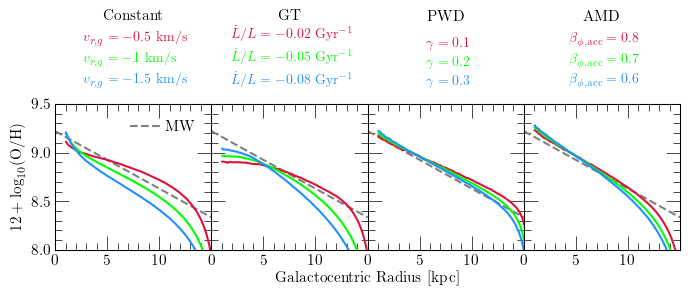

In [7]:
TITLES = [r"Constant", r"GT", r"PWD", r"AMD"]
COLORS = ["crimson", "lime", "dodgerblue"]
LABELS = [
    r"$v_{r,g} = -0.5$ km/s",
    r"$v_{r,g} = -1$ km/s",
    r"$v_{r,g} = -1.5$ km/s",
    r"$\dot L/L = -0.02$ Gyr$^{-1}$",
    r"$\dot L/L = -0.05$ Gyr$^{-1}$",
    r"$\dot L/L = -0.08$ Gyr$^{-1}$",
    r"$\gamma = 0.1$",
    r"$\gamma = 0.2$",
    r"$\gamma = 0.3$",
    r"$\beta_{\phi,\text{acc}} = 0.8$",
    r"$\beta_{\phi,\text{acc}} = 0.7$",
    r"$\beta_{\phi,\text{acc}} = 0.6$",
    # r"$-0.5$",
    # r"$-1$",
    # r"$-1.5$",
    # r"$-0.05$",
    # r"$-0.1$",
    # r"$-0.015$",
    # r"$0.1$",
    # r"$0.2$",
    # r"$0.3$",
    # r"$0.8$",
    # r"$0.7$",
    # r"$0.6$"
]

fig = plt.figure(figsize = (7, 3))
axes = []
for i in range(4):
    kwargs = {}
    if i:
        kwargs["sharex"] = axes[0]
        kwargs["sharey"] = axes[0]
    else: pass
    axes.append(fig.add_subplot(141 + i, **kwargs))
    if i: plt.setp(axes[i].get_yticklabels(), visible = False)
    axes[i].set_title(TITLES[i], fontsize = 11, pad = 60)
    axes[i].tick_params(labelsize = 11)
axes[0].set_xlim([0, 15])
axes[0].set_ylim([8, 9.5])
axes[0].set_xticks([0, 5, 10])
axes[0].set_yticks([8, 8.5, 9, 9.5])
axes[0].set_ylabel(r"$12 + \log_{10}$(O/H)", fontsize = 11)
dummy = fig.add_axes([0.1, 0.1, 0.8, 0.8], xticks = [], yticks = [], zorder = -1000)
dummy.set_xlabel(r"Galactocentric Radius [kpc]", fontsize = 11, labelpad = 15)

line = axes[0].plot([1, 2], [1, 2], c = named_colors()["grey"], linestyle = "--", label = "MW")[0]
leg = axes[0].legend(loc = mpl_loc("upper right"), fontsize = 11, handlelength = 2, bbox_to_anchor = (0.98, 0.98))
axes[0].add_artist(leg)
line.remove()

def mendezdelgado2022_profile():
    radii = np.linspace(axes[0].get_xlim()[0], axes[0].get_xlim()[1], 100)
#     oh = [np.log10(vice.solar_z.epsilon_to_z_conversion(9.22, 15.999) /
#                    vice.solar_z['o']) - 0.059 * r for r in radii]
    log_oh_plus12 = [9.22 - 0.059 * r for r in radii]
    return [radii, log_oh_plus12]

def plot_metallicity_profile(ax, output, lookback = 0, zone_width = 0.1, **kwargs):
    diff = [abs(_ - lookback) for _ in output.zones["zone0"].history["lookback"]]
    idx = diff.index(min(diff))
    radii = [zone_width * (i + 0.5) for i in range(len(output.zones.keys()))]
    oh = []
    for i in range(len(radii)):
        oh.append(oh_to_12pluslog(output.zones["zone%d" % (i)].history["[o/h]"][idx]))
    start = int(1 / zone_width)
    ax.plot(radii[start:], oh[start:], **kwargs)

radii, oh = mendezdelgado2022_profile()
for i in range(len(axes)):
    axes[i].plot(radii, oh, c = named_colors()["grey"], linestyle = "--")
for i in range(len(outputs)):
    kwargs = {
        "c": named_colors()[COLORS[i % len(COLORS)]],
        "label": LABELS[i]
    }
    plot_metallicity_profile(axes[i // 3], outputs[i], **kwargs)

kwargs = {
    "loc": mpl_loc("lower center"),
    "bbox_to_anchor": (0.5, 1.02),
    "ncol": 1,
    "handlelength": 0,
    "fontsize": 10
}
for i in range(len(axes)):
    # if i == 1: kwargs["bbox_to_anchor"] = (-0.05, 0.00)
    leg = axes[i].legend(**kwargs)
    fancy_legend(leg, COLORS)

plt.tight_layout()
plt.subplots_adjust(wspace = 0, bottom = 0.15)
dummy.set_position([
    axes[0].get_position().x0,
    axes[0].get_position().y0,
    axes[-1].get_position().x1 - axes[0].get_position().x0,
    axes[0].get_position().y1 - axes[0].get_position().y0
])
for ext in ["pdf", "jpeg"]:
    kwargs = {}
    if ext == "jpeg": kwargs["dpi"] = 200
    plt.savefig("./sfr-ifr/gradsteepen.%s" % (ext), **kwargs)
plt.show()

In [63]:
outputs = [
    # r"../outputs/constant/vgas-0",
    r"../outputs/constant/vgas-0p5-centraloutflow",
    r"../outputs/constant/vgas-1-centraloutflow",
    r"../outputs/constant/vgas-1p5-centraloutflow",
    r"../outputs/linear/dvdr-0p05-centraloutflow",
    r"../outputs/linear/dvdr-0p1-centraloutflow",
    r"../outputs/linear/dvdr-0p15-centraloutflow",
    r"../outputs/potential-well-deepening/gamma0p1",
    r"../outputs/potential-well-deepening/gamma0p2",
    r"../outputs/potential-well-deepening/gamma0p3",
    r"../outputs/angular-momentum-dilution/betaphiin0p8",
    r"../outputs/angular-momentum-dilution/betaphiin0p7",
    r"../outputs/angular-momentum-dilution/betaphiin0p6"
]
outputs = [vice.output(name) for name in outputs]

In [61]:
def equilibrium_profile(output, lookback, N = 1.5, zone_width = 0.1):
    if os.path.exists("%s_gasvelocities.out" % (output.name)):
        radii, mu_g, mu_o = mu(output, lookback, zone_width = zone_width)
    else:
        radii = [zone_width * i for i in range(len(output.zones.keys()))]
        mu_g = mu_o = len(radii) * [0.]
    radii = [r + zone_width / 2 for r in radii]
    diff = [abs(_ - lookback) for _ in output.zones["zone0"].history["lookback"]]
    idx = diff.index(min(diff))
    zeq = []
    for i in range(len(radii) - 1):
        zone = output.zones["zone%d" % (i)]
        if zone.history["sfr"][idx]:
            taustar = zone.history["mgas"][idx] / zone.history["sfr"][idx] * 1.e-9
            eta = zone.history["ofr"][idx] / zone.history["sfr"][idx]
        else:
            taustar = float("inf")
            eta = 0
        recycling = zone.history["r_eff"][idx]
        if idx == len(zone.history["time"]) - 1: idx -= 1
        dt = zone.history["time"][idx + 1] - zone.history["time"][idx]
        # dlnmgdt = zone.history["mgas"][idx + 1] - zone.history["mgas"][idx]
        # dlnmgdt /= dt * zone.history["mgas"][idx]
        # zeq.append(zone.ccsne_yields["o"] / (1 + eta - mu_o[i] - recycling + taustar * dlnmgdt))
        sfh = insideout(radii[i])
        tausfh = sfh.timescale
        zeq.append(zone.ccsne_yields["o"] / (1 + eta - mu_o[i] - recycling - taustar / (N * tausfh)))
    return [radii, zeq]


def equilibrium_evol(output, radius, N = 1.5, zone_width = 0.1):
    lookback, mu_g, mu_o = mu_evol(output, radius, zone_width = zone_width)
    zeq = []
    zone = int(radius / zone_width)
    zone = output.zones["zone%d" % (zone)]
    for i in range(len(lookback)):
        diff = [abs(lookback[i] - l) for l in zone.history["lookback"]]
        idx = diff.index(min(diff))
        if zone.history["sfr"][idx]:
            taustar = zone.history["mgas"][idx] / zone.history["sfr"][idx] * 1.e-9
            eta = zone.history["ofr"][idx] / zone.history["sfr"][idx]
        else:
            zeq.append(float("nan"))
            continue
        dt = zone.history["time"][idx] - zone.history["time"][idx - 1]
        # dlnmgdt = zone.history["mgas"][idx] - zone.history["mgas"][idx - 1]
        # dlnmgdt /= zone.history["mgas"][idx] * dt
        recycling = zone.history["r_eff"][idx]
        sfh = insideout(radius)
        tausfh = sfh.timescale
        zeq.append(zone.ccsne_yields["o"] / (1 + eta - mu_o[i] - recycling + taustar / (N * tausfh)))
    return [lookback, zeq]
    

def eq_gradient(output, lookback, zone_width = 0.1):
    diff = [abs(_ - lookback) for _ in output.zones["zone0"].history["lookback"]]
    idx = diff.index(min(diff))
    radii, zeq = equilibrium_profile(output, lookback, zone_width = 0.1)
    start = None
    stop = None
    i = 0
    while start is None or stop is None:
        if radii[i] >= 5 and start is None: start = i
        if radii[i] >= 10 and stop is None: stop = i
        i += 1
    oheq = [np.log10(z / vice.solar_z['o']) for z in zeq]
    # while m.isnan(oheq[start]): start += 1
    # while m.isnan(oheq[stop]): stop -= 1
    eqprof = linregress(radii[start:stop], oheq[start:stop])
    dlnzeq_dr = eqprof.slope * m.log(10)

    z_on_zeq = []
    lntaustar = []
    for i in range(start, stop):
        zone = output.zones["zone%d" % (i)]
        if zone.history["sfr"][idx]:
            lntaustar.append(m.log(zone.history["mgas"][idx] / zone.history["sfr"][idx] * 1.e-9))
        else:
            lntaustar.append(float("inf"))
        z_on_zeq.append(zone.history["z(o)"][idx] / zeq[i])
    z_on_zeq = np.mean(z_on_zeq)
    taustarprof = linregress(radii[start:stop], lntaustar)
    dlntaustar_dr = taustarprof.slope

    gradeq = z_on_zeq * dlnzeq_dr - (1 - z_on_zeq) * dlntaustar_dr
    return gradeq / m.log(10)
        
    




    # print(list(zip(radii[start:stop], zeq[start:stop])))
    # oheq = [np.log10(z / vice.solar_z['o']) for z in zeq[start:stop]]
    # radii = radii[start:stop]
    # stop -= start
    # start = 0
    # while m.isnan(oheq[start]): start += 1
    # while m.isnan(oheq[stop - 1]): stop -= 1
    # eqprof = linregress(radii[start:stop], oheq[start:stop])
    # return eqprof.slope
    
    # diff = [abs(_ - lookback) for _ in output.zones["zone0"].history["lookback"]]
    # idx = diff.index(min(diff))
    # z_on_zeq = []
    # dlnzeq_dr = []
    # dlntaustar_dr = []
    # for i in range(start, stop):
    #     zone = output.zones["zone%d" % (i)]
    #     neighbor = output.zones["zone%d" % (i + 1)]
    #     z_on_zeq.append(zone.history["z(o)"][idx] / zeq[i])
    #     dlnzeq_dr.append((zeq[i + 1] - zeq[i]) / (zeq[i] * zone_width))
    #     if zone.history["sfr"][idx]:
    #         taustar = zone.history["mgas"][idx] / zone.history["sfr"][idx] * 1.e-9
    #     else:
    #         taustar = float("inf")
    #     if neighbor.history["sfr"][idx]:
    #         taustar_n = neighbor.history["mgas"][idx] / neighbor.history["sfr"][idx] * 1.e-9
    #     else:
    #         taustar_n = float("inf")
    #     dlntaustar_dr.append((taustar_n - taustar) / (taustar * zone_width))
    # z_on_zeq = np.mean(z_on_zeq)
    # dlnzeq_dr = np.mean(dlnzeq_dr)
    # dlntaustar_dr = np.mean(dlntaustar_dr)
    # gradeq = z_on_zeq * dlnzeq_dr - (1 - z_on_zeq) * dlntaustar_dr
    # gradeq /= m.log(10)
    # return gradeq
    
    # return dlnzeq_dr / m.log(10)
    # gradeq = []
    # for i in range(start, stop):
    #     zone = output.zones["zone%d" % (i)]
    #     neighbor = output.zones["zone%d" % (i + 1)]
    #     if zone.history["sfr"][idx]:
    #         taustar = zone.history["mgas"][idx] / zone.history["sfr"][idx] * 1.e-9
    #     else:
    #         taustar = float("inf")
    #     if neighbor.history["sfr"][idx]:
    #         taustar_n = neighbor.history["mgas"][idx] / neighbor.history["sfr"][idx] * 1.e-9
    #     else:
    #         taustar_n = float("inf")
    #     dlnzeq_dr = (zeq[i + 1] - zeq[i]) / (zeq[i] * zone_width)
    #     print(dlnzeq_dr)
    #     dlntaustar_dr = (taustar_n - taustar) / (taustar * zone_width)
    #     z_on_zeq = zone.history["z(o)"][idx] / zeq[i]
    #     gradeq.append(z_on_zeq * dlnzeq_dr - (1 - z_on_zeq) * dlntaustar_dr)
    # gradeq = np.mean(gradeq) / m.log(10)
    # return gradeq
    

def ism_gradient(output, lookback, inner = 5, outer = 10, zone_width = 0.1):
    radii = [zone_width * (i + 0.5) for i in range(len(output.zones.keys()))]
    diff = [abs(_ - lookback) for _ in output.zones["zone0"].history["lookback"]]
    idx = diff.index(min(diff))
    oh = []
    start = None
    stop = None
    i = 0
    while start is None or stop is None:
        if radii[i] >= inner and start is None: start = i
        if radii[i] > outer and stop is None: stop = i
        i += 1
    for i in range(start, stop):
        zone = output.zones["zone%d" % (i)]
        oh.append(zone.history["[o/h]"][idx])
    # print(list(zip(radii[start:stop], oh)))
    ohprof = linregress(radii[start:stop], oh)
    return ohprof.slope

/var/folders/26/nqb98q9x5_q6brmqy4v21dqm0000gp/T/ipykernel_96644/1543304768.py:94: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


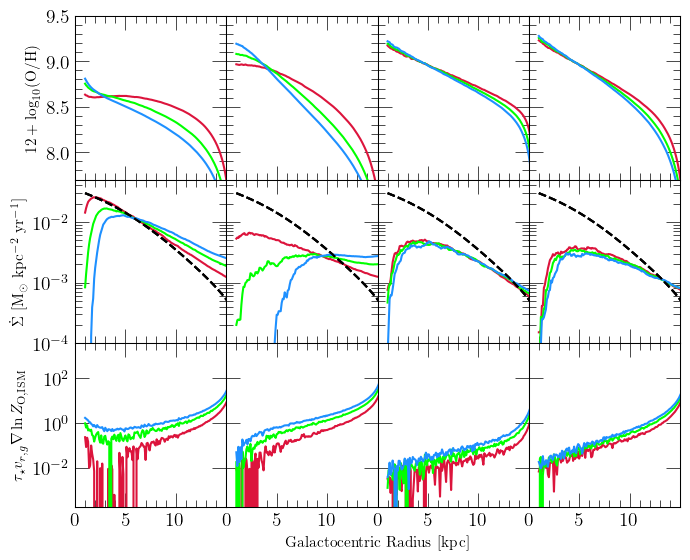

In [65]:
COLORS = [
    "crimson", "lime", "dodgerblue"
]

# fig = plt.figure(figsize = (7, 7))
# top = []
# middle = []
# bottom = []
# for i in range(4):
#     kwargs = {}
#     if i:
#         kwargs["sharex"] = top[0]
#         kwargs["sharey"] = top[0]
#     else: pass
#     top.append(fig.add_subplot(3, 4, 1 + i, **kwargs))
#     if i:
#         kwargs["sharey"] = bottom[0]
#     else:
#         kwargs["sharex"] = top[0]
#         kwargs["sharey"] = None
#     middle.append(fig.add_subplot(3, 4, 5 + i, 
#     bottom.append(fig.add_subplot(245 + i, **kwargs))
#     plt.setp(top[i].get_xticklabels(), visible = False)
#     if i:
#         plt.setp(top[i].get_yticklabels(), visible = False)
#         plt.setp(bottom[i].get_yticklabels(), visible = False)
#     else: pass
#     for ax in [top[i], bottom[i]]: ax.tick_params(labelsize = 11)
fig, (top, middle, bottom) = plt.subplots(figsize = (7, 5.5), nrows = 3, ncols = 4, sharex = True, sharey = "row")
top[0].set_xlim([0, 15])
top[0].set_xticks([0, 5, 10])
top[0].set_ylim([7.7, 9.5])
top[0].set_yticks([8, 8.5, 9, 9.5])
middle[0].set_ylim([1.0e-4, 0.05])
middle[0].set_yscale("log")
bottom[0].set_yscale("log")
# bottom[0].set_ylim([0, 3])
dummy = fig.add_axes([0.1, 0.1, 0.8, 0.8], xticks = [], yticks = [], zorder = -1000)
dummy.set_xlabel(r"Galactocentric Radius [kpc]", labelpad = 20, fontsize = 11)
top[0].set_ylabel(r"$12 + \log_{10}$(O/H)", fontsize = 11)
middle[0].set_ylabel(r"$\dot\Sigma$ [M$_\odot$ kpc$^{-2}$ yr$^{-1}$]", fontsize = 11)
bottom[0].set_ylabel(r"$\tau_\star v_{r,g} \nabla \ln Z_\text{O,ISM}$", fontsize = 11)

def boxcarsmoothtrend(xvals, yvals, window = 5):
    newyvals = []
    for i in range(len(xvals)):
        start = max(0, i - window)
        stop = min(i + window, len(xvals) - 1)
        newyvals.append(np.mean(yvals[start:stop]))
    return newyvals

def plot_profiles(ax_oh, ax_sigma, ax_mix, output, lookback = 0, zone_width = 0.1, **kwargs):
    diff = [abs(_ - lookback) for _ in output.zones["zone0"].history["lookback"]]
    idx = diff.index(min(diff))
    # radii = [zone_width * (i + 0.5) for i in range(len(output.zones.keys()))]
    if os.path.exists("%s_gasvelocities.out" % (output.name)):
        radii, vgas = get_velocity_profile(output, lookback)
    else:
        radii = [zone_width * (i + 0.5) for i in range(len(output.zones.keys()))]
        vgas = len(radii) * [0.]
    oh = []
    sigma_sfr = []
    sigma_ifr = []
    mixing = []
    for i in range(len(radii)):
        zone = output.zones["zone%d" % (i)]
        area = np.pi * zone_width**2 * ((i + 1)**2 - i**2)
        oh.append(oh_to_12pluslog(zone.history["[o/h]"][idx]))
        sigma_sfr.append(zone.history["sfr"][idx] / area)
        sigma_ifr.append(zone.history["ifr"][idx] / area)
        if i < len(radii) - 1:
            tau_star = zone.history["mgas"][idx] / zone.history["sfr"][idx] * 1.0e-9
            neighbor = output.zones["zone%d" % (i + 1)]
            dlnzdr = (neighbor.history["z(o)"][idx] - zone.history["z(o)"][idx]) / (zone.history["z(o)"][idx] * zone_width)
            mixing.append(tau_star * vgas[i] * dlnzdr)
        else:
            mixing.append(float("nan"))
    start = int(1 / zone_width)
    ax_oh.plot(radii[start:], oh[start:], **kwargs)
    ax_mix.plot(radii[start:], mixing[start:], **kwargs)
    sigma_ifr = boxcarsmoothtrend(radii, sigma_ifr)
    ax_sigma.plot(radii[start:], sigma_ifr[start:], **kwargs)
    kwargs["c"] = named_colors()["black"]
    kwargs["linestyle"] = "--"
    ax_sigma.plot(radii[start:], sigma_sfr[start:], **kwargs)

for i in range(len(outputs)):
    kwargs = {
        "c": named_colors()[COLORS[i % 3]]
    }
    # plot_profiles(top[0], bottom[0], outputs[i], **kwargs)
    plot_profiles(top[i // 3], middle[i // 3], bottom[i // 3], outputs[i], **kwargs)

plt.tight_layout()
plt.subplots_adjust(hspace = 0, wspace = 0)
dummy.set_position([
    bottom[0].get_position().x0,
    bottom[0].get_position().y0,
    bottom[-1].get_position().x1 - bottom[0].get_position().x0,
    top[0].get_position().y1 - bottom[0].get_position().y0
])
plt.show()

In [65]:
outputs = [
    # "../outputs/linear/dvdr-0p1",
    "../outputs/constant/vgas-1",
    "../outputs/constant/vgas-1-centraloutflow",
    "../outputs/linear/dvdr-0p1-centraloutflow",
    # "../outputs/linear/dvdr-0p1-centraloutflow4",
    # "../outputs/constant/vgas-0p5",
    # "../outputs/constant/vgas-1",
    # "../outputs/constant/vgas-1-centraloutflow",
    # "../outputs/constant/vgas-1p5",
    # "../outputs/linear/dvdr-0p1-centraloutflow1",
    "../outputs/potential-well-deepening/gamma0p1",
    "../outputs/potential-well-deepening/gamma0p2",
    "../outputs/potential-well-deepening/gamma0p3",
    "../outputs/angular-momentum-dilution/betaphiin0p8",
    "../outputs/angular-momentum-dilution/betaphiin0p7",
    "../outputs/angular-momentum-dilution/betaphiin0p6"
]
outputs = [vice.output(name) for name in outputs]

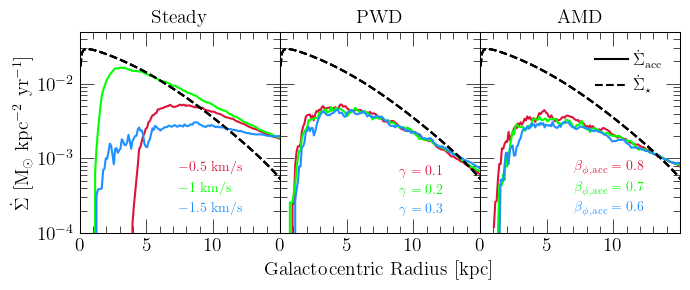

In [66]:
TITLES = [r"Steady", r"PWD", r"AMD"]
COLORS = ["crimson", "lime", "dodgerblue"]
LABELS = [
    r"$-0.5$ km/s",
    r"$-1$ km/s",
    r"$-1.5$ km/s",
    r"$\gamma = 0.1$",
    r"$\gamma = 0.2$",
    r"$\gamma = 0.3$",
    r"$\beta_{\phi,\text{acc}} = 0.8$",
    r"$\beta_{\phi,\text{acc}} = 0.7$",
    r"$\beta_{\phi,\text{acc}} = 0.6$"
]

fig = plt.figure(figsize = (7, 3))
axes = []
for i in range(3):
    axes.append(fig.add_subplot(131 + i))
    if i:
        plt.setp(axes[i].get_yticklabels(), visible = False)
    else:
        axes[i].set_ylabel(r"$\dot\Sigma$ [M$_\odot$ kpc$^{-2}$ yr$^{-1}$]")
    axes[i].set_title(TITLES[i])
    axes[i].set_xlim([0, 15])
    axes[i].set_xticks([0, 5, 10])
    axes[i].set_yscale("log")
    axes[i].set_ylim([1e-4, 5e-2])
axes[1].set_xlabel(r"Galactocentric Radius [kpc]")

kwargs = {
    "c": named_colors()["black"],
    "linestyle": "-",
    "label": r"$\dot \Sigma_\text{acc}$"
}
line1 = axes[-1].plot([1, 2], [1, 2], **kwargs)[0]
kwargs["linestyle"] = "--"
kwargs["label"] = r"$\dot \Sigma_\star$"
line2 = axes[-1].plot([1, 2], [1, 2], **kwargs)[0]
kwargs = {
    "loc": mpl_loc("upper right"),
    "bbox_to_anchor": (0.98, 0.98),
    # "handlelength": 1.5,
    "fontsize": 12
}
leg = axes[-1].legend(**kwargs)
axes[-1].add_artist(leg)
line1.remove()
line2.remove()

def plot_profiles(ax, output, lookback = 0, zone_width = 0.1, **kwargs):
    diff = [abs(_ - lookback) for _ in output.zones["zone0"].history["lookback"]]
    idx = diff.index(min(diff))
    n_zones = int(15.5 / zone_width)
    radii = [zone_width * (i + 0.5) for i in range(n_zones)]
    sigma_ifr = []
    sigma_sfr = []
    dlnsigmaifr_dr = []
    dlnsigmasfr_dr = []
    for i in range(len(radii)):
        area = np.pi * ((radii[i] + zone_width)**2 - radii[i]**2)
        zone = output.zones["zone%d" % (i)]
        sigma_ifr.append(zone.history["ifr"][idx] / area)
        sigma_sfr.append(zone.history["sfr"][idx] / area)
    sigma_ifr = boxcarsmoothtrend(radii, sigma_ifr, window = 3)
    if "c" in kwargs.keys() and kwargs["c"] == named_colors()["black"]: kwargs["zorder"] = -1000
    start = int(1 / zone_width)
    if "angular-momentum-dilution" in output.name:
        ax.plot(radii[start:], sigma_ifr[start:], linestyle = "-", **kwargs)
    else:
        ax.plot(radii, sigma_ifr, linestyle = "-", **kwargs)
    kwargs["c"] = named_colors()["black"]
    if "label" in kwargs.keys() and kwargs["label"] is not None: kwargs["label"] = None
    ax.plot(radii, sigma_sfr, linestyle = "--", **kwargs)

for i in range(len(outputs)):
    kwargs = {
        "c": named_colors()[COLORS[i % 3]],
        "label": LABELS[i]
    }
    plot_profiles(axes[i // 3], outputs[i], **kwargs)

for i in range(len(axes)):
    kwargs = {
        "loc": mpl_loc("lower right"),
        "bbox_to_anchor": (0.88, 0.02),
        "handlelength": 0,
        "fontsize": 10
    }
    leg = axes[i].legend(**kwargs)
    fancy_legend(leg, COLORS)

plt.tight_layout()
plt.subplots_adjust(wspace = 0)
# for ext in ["pdf", "jpeg"]:
#     kwargs = {}
#     if ext == "jpeg": kwargs["dpi"] = 200
#     plt.savefig("./sfr-ifr/ifrshift-scenariocomp.%s" % (ext), **kwargs)
plt.show()

In [2]:
reference = vice.output("../outputs/constant/vgas-0")

In [3]:
outputs = [
    "../outputs/constant/vgas-0p5",
    "../outputs/constant/vgas-1",
    "../outputs/constant/vgas-1p5"
    # "../outputs/potential-well-deepening/gamma0p1",
    # "../outputs/potential-well-deepening/gamma0p2",
    # "../outputs/potential-well-deepening/gamma0p3"
    # "../outputs/angular-momentum-dilution/betaphiin0p8",
    # "../outputs/angular-momentum-dilution/betaphiin0p7",
    # "../outputs/angular-momentum-dilution/betaphiin0p6"
]
outputs = [vice.output(name) for name in outputs]

/var/folders/26/nqb98q9x5_q6brmqy4v21dqm0000gp/T/ipykernel_40248/3039520601.py:112: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
/Users/jamesjohnson/Work/Research/lib/personal/plots/mpltoolkit/core.py:96: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(labels)


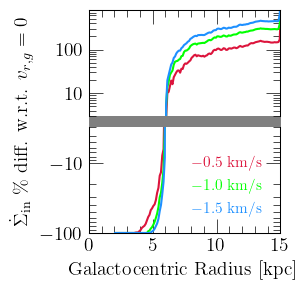

In [22]:
# LOGFACTOR = 3
COLORS = ["crimson", "lime", "dodgerblue"]
LABELS = [r"$%.1f$ km/s" % (v) for v in [-0.5, -1, -1.5]]
# GRAD = [-0.052, -0.063, -0.069]
# LABELS = [r"$\gamma = 0.1$", r"$\gamma = 0.2$", r"$\gamma = 0.3$"]
# GRAD = [-0.051, -0.060, -0.067]
# LABELS = [r"$\beta_{\phi,\text{in}} = %g$" % (b) for b in [0.8, 0.7, 0.6]]
# GRAD = [-0.061, -0.072, -0.081]

fig = plt.figure(figsize = (3, 3))
# ax = fig.add_subplot(111)
# ax.set_xlabel(r"Galactocentric Radius [kpc]")
# ax.set_ylabel(r"$\dot \Sigma_\text{in} / \dot \Sigma_\text{in}(v_{r,g} = 0)$ [$\times$ 10$^{-%d}$]" % (LOGFACTOR))
# ax.set_xlim([0, 15])
# ax.set_ylim([-3, 3])
# ax.set_yticks([-2, 0, 2])
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212, sharex = ax1)
for ax in [ax1, ax2]:
    ax.set_yscale("log")
    ax.yaxis.set_major_formatter(fsf("%g"))
# ax1.set_yscale("log")
# ax2.set_yscale("log")
plt.setp(ax1.get_xticklabels(), visible = False)
ax2.set_xlabel(r"Galactocentric Radius [kpc]")
dummy = fig.add_axes([0.1, 0.1, 0.8, 0.8], xticks = [], yticks = [], zorder = -1000)
dummy.spines["left"].set_visible(False)
dummy.spines["right"].set_visible(False)
# dummy.set_ylabel(r"$\dot \Sigma_\text{in} / \dot \Sigma_\text{in}(v_{r,g} = 0)$", labelpad = 40)
dummy.set_ylabel(r"$\dot \Sigma_\text{in}$ \% diff. w.r.t. $v_{r,g} = 0$", labelpad = 40)
ax1.set_xlim([0, 15])
ax1.set_ylim([3, 800]) # Constant
ax2.set_ylim([3, 100])
# ax1.set_ylim([0.02, 1.e0]) # PWD
# ax2.set_ylim([0.02, 1.e0])
dummy.set_xlim([0, 15])
dummy.set_ylim([0, 1])
kwargs = {
    "axis": "x",
    "which": "both",
    "bottom": False
}
ax1.tick_params(**kwargs)
kwargs["bottom"] = True
kwargs["top"] = False
ax2.tick_params(**kwargs)
ax1.spines["bottom"].set_visible(False)
ax2.spines["top"].set_visible(False)

def ifr_snapshot(output, lookback, zone_width = 0.1):
    diff = [abs(_ - lookback) for _ in output.zones["zone0"].history["lookback"]]
    idx = diff.index(min(diff))
    n_zones = len(output.zones.keys())
    radii = [zone_width * (i + 0.5) for i in range(n_zones)]
    ifr = [output.zones["zone%d" % (i)].history["ifr"][idx] for i in range(n_zones)]
    return [radii, ifr]

def plot_diff(ax_pos, ax_neg, output, reference, lookback, zone_width = 0.1, **kwargs):
    # print('a')
    radii, ifr = ifr_snapshot(output, lookback, zone_width = zone_width)
    # print('b')
    _, ref_ifr = ifr_snapshot(reference, lookback, zone_width = zone_width)
    # print('c')
    yvals = [100 * (a / b - 1) if b else float("nan") for a, b in zip(ifr, ref_ifr)]
    yvals = boxcarsmoothtrend(radii, yvals, window = 5)
    ax_pos.plot(radii, yvals, **kwargs)
    # if kwargs["label"] is not None: kwargs["label"] = None
    ax_neg.plot(radii, [-y for y in yvals], **kwargs)

# lines = []
# for i in range(len(outputs)):
#     kwargs = {
#         "c": named_colors()[COLORS[i]],
#         "label": LABELS[i]
#         # "label": r"$\nabla = %.3f$ kpc$^{-1}$" % (GRAD[i])
#     }
#     lines.append(
#         ax2.plot([1, 2], [1, 2], **kwargs)[0]
#     )
# kwargs = {
#     "loc": mpl_loc("lower right"),
#     "bbox_to_anchor": (0.98, 0.02),
#     "handlelength": 0,
#     "fontsize": 11
# }
# leg = ax2.legend(**kwargs)
# fancy_legend(leg, COLORS)
# ax2.add_artist(leg)
# for line in lines: line.remove()

for i in range(len(outputs)):
    kwargs = {
        "c": named_colors()[COLORS[i]],
        "label": LABELS[i]
        # "label": r"$%.3f$ kpc$^{-1}$" % (GRAD[i])
        # "label": r"%s; $\nabla = %.3f$ kpc$^{-1}$" % (LABELS[i], GRAD[i])
    }
    plot_diff(ax1, ax2, outputs[i], reference, 0, **kwargs)

# ax.axhline(0, c = named_colors()["black"], linestyle = ":")

kwargs = {
    "loc": mpl_loc("lower right"),
    "bbox_to_anchor": (0.98, 0.02),
    "handlelength": 0,
    "fontsize": 11
}
leg = ax2.legend(**kwargs)
fancy_legend(leg, COLORS)

h = 0.1
plt.tight_layout()
negative_log(ax2)
plt.subplots_adjust(left = 0.28, hspace = h)
dummy.fill_between(dummy.get_xlim(), 2 * [0.5 - h / 2], 2 * [0.5 + h / 2],
    color = named_colors()["grey"])
dummy.set_position([
    ax1.get_position().x0,
    ax2.get_position().y0,
    ax1.get_position().x1 - ax1.get_position().x0,
    ax1.get_position().y1 - ax2.get_position().y0
])
for ext in ["pdf", "jpeg"]:
    kwargs = {}
    if ext == "jpeg": kwargs["dpi"] = 200
    plt.savefig("./sfr-ifr/ifrshift-constant.%s" % (ext), **kwargs)
    # plt.savefig("./sfr-ifr/ifrshift-pwd.%s" % (ext), **kwargs)
    # plt.savefig("./sfr-ifr/ifrshift-amd.%s" % (ext), **kwargs)
plt.show()

In [5]:
outputs = [
    "../outputs/potential-well-deepening/gamma0p1",
    "../outputs/potential-well-deepening/gamma0p2",
    # "../outputs/constant/vgas-0",
    "../outputs/potential-well-deepening/gamma0p3"
]
outputs = [vice.output(name) for name in outputs]

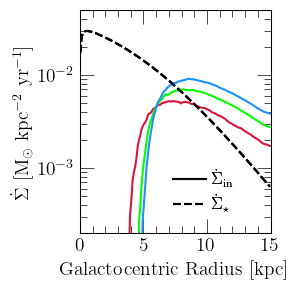

In [26]:
# COLORS = ["black", "crimson", "lime", "royalblue"]
# COLORS = ["black", "crimson", "dodgerblue"]
# COLORS = ["crimson", "black", "dodgerblue"]
COLORS = ["crimson", "lime", "dodgerblue"]
LABELS = [
    r"$v_{r,g} = -0.5$ km/s",
    r"$v_{r,g} = -1.0$ km/s",
    r"$v_{r,g} = -1.5$ km/s"
    # r"$\gamma = 0.1$",
    # r"$\gamma = 0.2$",
    # r"$\gamma = 0.3$"
    # r"$\beta_{\phi,\text{in}} = 0.8$",
    # r"$\beta_{\phi,\text{in}} = 0.7$",
    # r"$\beta_{\phi,\text{in}} = 0.6$"
]

fig = plt.figure(figsize = (3, 3))
ax = fig.add_subplot(111)
# res = fig.add_axes([0.1, 0.1, 0.8, 0.1], sharex = ax)
# plt.setp(ax.get_xticklabels(), visible = False)
# res.set_xlabel(r"Galactocentric Radius [kpc]")
ax.set_xlabel(r"Galactocentric Radius [kpc]")
ax.set_ylabel(r"$\dot \Sigma$ [M$_\odot$ kpc$^{-2}$ yr$^{-1}$]")
# res.set_ylabel(r"$\frac{\partial \ln \dot \Sigma}{\partial R}$ [kpc$^{-1}$]")
ax.set_yscale("log")
ax.set_xlim([0, 15])
ax.set_ylim([2.e-4, 0.05])
# res.set_ylim([-0.5, 0.5])
# res.set_yticks([-0.2, 0, 0.2])

# def plot_profiles(ax, res, output, lookback, zone_width = 0.1, **kwargs):
def plot_profiles(ax, output, lookback, zone_width = 0.1, **kwargs):
    diff = [abs(_ - lookback) for _ in output.zones["zone0"].history["lookback"]]
    idx = diff.index(min(diff))
    # n_zones = len(output.zones.keys())
    n_zones = 150
    radii = [zone_width * (i + 0.5) for i in range(n_zones)]
    sigma_ifr = []
    sigma_sfr = []
    dlnsigmaifr_dr = []
    dlnsigmasfr_dr = []
    for i in range(len(radii)):
        area = np.pi * ((radii[i] + zone_width)**2 - radii[i]**2)
        zone = output.zones["zone%d" % (i)]
        sigma_ifr.append(zone.history["ifr"][idx] / area)
        sigma_sfr.append(zone.history["sfr"][idx] / area)
        # if i < len(radii) - 1:
        #     n_area = np.pi * ((radii[i + 1] + zone_width)**2 - radii[i + 1]**2)
        #     n_zone = output.zones["zone%d" % (i + 1)]
        #     n_sigma_ifr = n_zone.history["ifr"][idx] / n_area
        #     n_sigma_sfr = n_zone.history["sfr"][idx] / n_area
        #     if sigma_ifr[-1]:
        #         if sigma_ifr[-1] < 0: print(sigma_ifr[-1])
        #         dlnsigmaifr_dr.append(
        #             (n_sigma_ifr - sigma_ifr[-1]) / (sigma_ifr[-1] * zone_width)
        #         )
        #     else:
        #         dlnsigmaifr_dr.append(float("nan"))
        #     if sigma_sfr[-1]:
        #         dlnsigmasfr_dr.append(
        #             (n_sigma_sfr - sigma_sfr[-1]) / (sigma_sfr[-1] * zone_width)
        #         )
        #     else:
        #         dlnsigmasfr_dr.append(float("nan"))
        # else: pass
    sigma_ifr = boxcarsmoothtrend(radii, sigma_ifr, window = 5)
    # dlnsigmaifr_dr = boxcarsmoothtrend(radii[:-1], dlnsigmaifr_dr, window = 10)
    if "c" in kwargs.keys() and kwargs["c"] == named_colors()["black"]: kwargs["zorder"] = -1000
    ax.plot(radii, sigma_ifr, linestyle = "-", **kwargs)
    # res.plot(radii[:-1], dlnsigmaifr_dr, **kwargs)
    # if "c" in kwargs.keys() and kwargs["c"] == named_colors()["black"]: kwargs["zorder"] = 1000
    kwargs["c"] = named_colors()["black"]
    if "label" in kwargs.keys() and kwargs["label"] is not None: kwargs["label"] = None
    ax.plot(radii, sigma_sfr, linestyle = "--", **kwargs)
    # res.plot(radii[:-1], dlnsigmasfr_dr, linestyle = "--", **kwargs)

kwargs = {
    "c": named_colors()["black"],
    "linestyle": "-",
    "label": r"$\dot \Sigma_\text{in}$"
}
line1 = ax.plot([1, 2], [1, 2], **kwargs)[0]
kwargs["linestyle"] = "--"
kwargs["label"] = r"$\dot \Sigma_\star$"
line2 = ax.plot([1, 2], [1, 2], **kwargs)[0]
kwargs = {
    "loc": mpl_loc("lower right"),
    "bbox_to_anchor": (0.88, 0.02),
    # "handlelength": 1.5,
    "fontsize": 12
}
leg = ax.legend(**kwargs)
ax.add_artist(leg)
line1.remove()
line2.remove()

for i in range(len(outputs)):
    kwargs = {
        "c": named_colors()[COLORS[i]],
        "label": LABELS[i]
    }
    # plot_profiles(ax, res, outputs[i], 0, **kwargs)
    plot_profiles(ax, outputs[i], 0, **kwargs)

# kwargs = {
#     "loc": mpl_loc("lower right"),
#     "bbox_to_anchor": (0.68, 0.02),
#     "handlelength": 0,
#     "fontsize": 11,
#     "ncol": 1,
#     "columnspacing": 1
# }
# leg = ax.legend(**kwargs)
# fancy_legend(leg, COLORS)

# reswidth = 0.35
plt.tight_layout()
# res.set_position([
#     ax.get_position().x0,
#     ax.get_position().y0,
#     ax.get_position().x1 - ax.get_position().x0,
#     reswidth
# ])
# ax.set_position([
#     ax.get_position().x0,
#     ax.get_position().y0 + reswidth,
#     ax.get_position().x1 - ax.get_position().x0,
#     ax.get_position().y1 - ax.get_position().y0 - reswidth
# ])
for ext in ["pdf", "jpeg"]:
    kwargs = {}
    if ext == "jpeg": kwargs["dpi"] = 200
    plt.savefig("./sfr-ifr/sfr-ifr-profiles-constant.%s" % (ext), **kwargs)
plt.show()